# Linear Regression on to a Climate Index

This notebook shows a relatively easy implementation for linear regression across spatial points on to a single time series like some climate index.

In [4]:
#
# Construct a "climate index" and then find the regression coefficient at all locations
#
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# Monthly 2m air temperature anomalies
ds = xr.open_dataset("/Users/brianpm/Library/CloudStorage/Dropbox/Data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc")

ds = ds.rename({"latitude":"lat", "longitude":"lon"})
# note lon is -180 to 180
ds

<xarray.Dataset>
Dimensions:           (time: 2077, lat: 36, lon: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-01-1...
  * lat               (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon               (lon) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, lat, lon) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (lat, bnds) float64 ...
    longitude_bnds    (lon, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2023-03-13T12:56:52+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [20]:
# simple ENSO index
nino34sst = ds['tas_mean'].sel(lat=slice(-5,5), lon=slice(-170,-120))
nino34sst = nino34sst.weighted(np.cos(np.radians(nino34sst.lat))).mean(dim=("lat","lon")).compute()
nino34sst_30yr = nino34sst.rolling(time=30*12, center=True).mean().compute()
oni = (nino34sst - nino34sst_30yr).rolling(time=3).mean()
elnino = xr.where(oni > 0.5, oni, np.nan)


In [35]:

# take subset that doesn't have missing values in ONI 
# this is just to illustrate the calculation
oni_sub = oni.sel(time=slice("1940-01-01","2000-01-01"))
ds_sub = ds.sel(time=slice("1940-01-01","2000-01-01"))

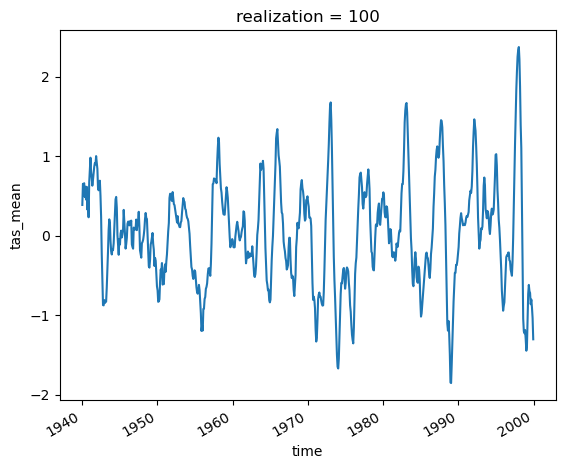

In [36]:
# Quick look at the time series of ONI
oni_sub.plot()

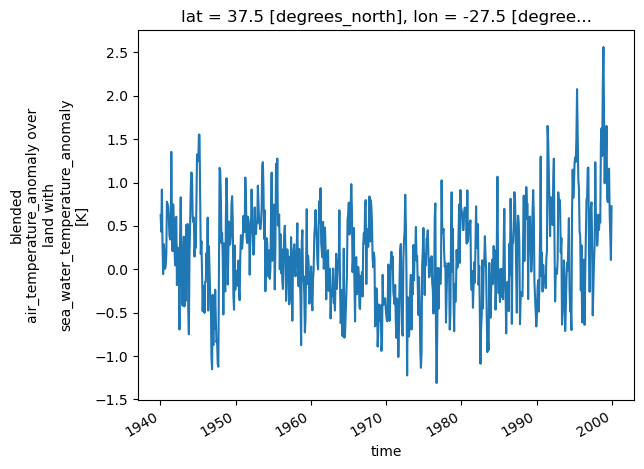

In [38]:
# now let's find the regression of some arbitrary point against our ONI series
azores = ds_sub.sel(lat=37.7, lon=-25.6, method='nearest')

# Quick look at the time series at this point
azores['tas_mean'].plot()


In [47]:
# least squares fit
fit = np.linalg.lstsq(np.vstack([oni_sub.values, np.ones(len(oni_sub.values))]).T, azores['tas_mean'].values, rcond=None)

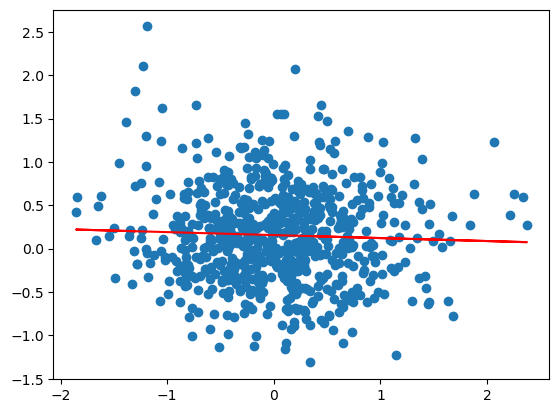

In [59]:
# Take a look at the linear fit through the scatter plot
fig, ax = plt.subplots()
timeaxis = oni_sub.time.dt.year + oni_sub.time.dt.dayofyear/365
ax.scatter(oni_sub, azores['tas_mean'])
ax.plot(oni_sub, fit[0][0]*oni_sub + fit[0][1], color='red')

In [63]:
%%time
#
# Apply similar fit to all locations
#

ds_stack = ds_sub.stack(z=("lat","lon")) # "stack" the spatial dimensions into a single dimension

fits = np.linalg.lstsq(np.vstack([oni_sub.values, np.ones(len(oni_sub.values))]).T,
                       ds_stack['tas_mean'].values,
                       rcond=None)

CPU times: user 19.2 ms, sys: 5.29 ms, total: 24.5 ms
Wall time: 19.6 ms


In [79]:
print(fits[0].shape)

# put the regression coefficient (slope) into DataArray
rcoef = xr.DataArray(fits[0][0,:], coords={'z':ds_stack['z']})
rcoef = rcoef.unstack()

(2, 2592)


In [71]:
fits[0][0,:]

array([        nan,         nan,         nan, ..., -0.1808363 ,
       -0.17665218, -0.17279716])

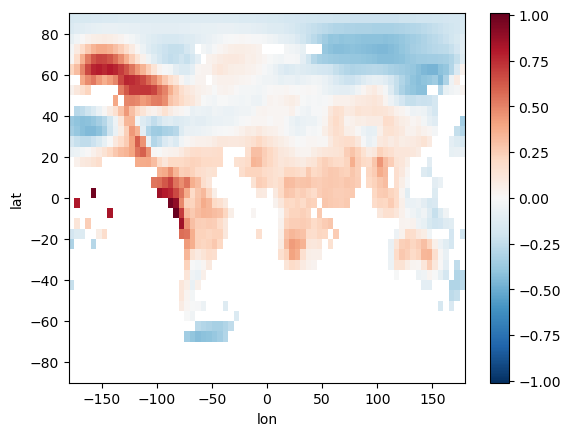

In [81]:
# quick look at the regression coefficients
rcoef.plot.pcolormesh()